# CAPSTONE

**Identifying Fake News**

**Project Overview**

The goal of this project is to create a fake new identification system using natural language processing (NLP). My data set consists of over 40 thousand articles obtained from Kaggle. A variety of machine learning models have been used to generate the best results.

**Business Case**

Over the course of the past decade, the amount of fake news being shared on social media has seen a dramatic increase. According to NewsGuard, "in 2019, 8 percent of engagement with the 100 top-performing news sources on social media was dubious. In 2020, that number more than doubled to 17 percent" ([Vox](https://www.vox.com/policy-and-politics/2020/12/22/22195488/fake-news-social-media-2020)). In 2021, the Daily Wire, the outlet founded by right-wing comentator Ben Shapiro, was the most popular news platform on Facebook.

From casting doubts on the results of the 2020 presidential election to spreading misinformation about the COVID vaccine, fake news is causing real damage to our society.

Because the main source of fake news is social media sites, such as Facebook and Twitter, I set out to produce a fake news identification system that can be used by social media companies to filter out minsinformation. A altnerative use of this system could be a web app with which users can verify the authenticity of a story themselves.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer
import string
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
#from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import spacy
import re
from sklearn.dummy import DummyClassifier
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
import requests
from os import path
import pickle
from nltk.util import ngrams
import nltk, re, string, collections

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acumu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# # loading in all the essentials for data manipulation
# import pandas as pd
# import numpy as np
# #load inthe NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.corpus import stopwords
# # This allows to create individual objects from a bog of words
from nltk.tokenize import word_tokenize
# # Lemmatizer helps to reduce words to the base form
# from nltk.stem import WordNetLemmatizer
# # Ngrams allows to group words in common pairs or trigrams..etc
from nltk import ngrams
# # We can use counter to count the objects
from collections import Counter
# # This is our visual library
import seaborn as sns
# import matplotlib.pyplot as plt

## Import CSVs and Data Cleaning

**Spacy Preprocessing Functions**

In [3]:
# Import list of stopwords from SpaCy
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
# Create a function to tokenize the text of the articles
punctuation = [*string.punctuation , *[str(x) for x in list(range(0,10))]]
nlp = spacy.load('en_core_web_sm')
def normalize(text):
    text = ''.join([x for x in text if x not in punctuation])
    toks = nlp(text)
    toks = [word.lemma_.lower().strip() for word in toks if word.pos_ != 'PRON']
    toks = [word for word in toks if word not in stop_words]
    return ' '.join(toks)

**Real News**

In [5]:
# Import real news articles
df_true = pd.read_csv('True.csv')
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
# Create target column
df_true = df_true.assign(status = 'Real')
df_true.head()

,title,text,subject,date,status
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real


In [8]:
# Remove city names and news sources from 'text' column
df_true['text']=df_true['text'].str.extract(r'(?<=\-\s)(.*)')

In [9]:
df_true.head()

,title,text,subject,date,status
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",Real


In [10]:
df_true.shape

(21417, 5)

In [11]:
# Check for missing data
df_true.isnull().sum()

title       0
text       21
subject     0
date        0
status      0
dtype: int64

In [12]:
# Drop articles missing text
df_true.dropna(inplace=True)

In [13]:
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
status     0
dtype: int64

In [ ]:
# Apply tokenization function to the real articles. Create a new column for the processed articles
df_true['processed_articles'] = df_true['text'].map(lambda x: normalize(x))

In [ ]:
list(df_true.processed_articles)

In [ ]:
# Save the new processed data frame
pickle_out = open('pickled_files/df_spacy_true.pickle',"wb")
pickle.dump(df_true, pickle_out)
pickle_out.close()

In [14]:
infile = open('pickled_files/df_spacy_true.pickle','rb')
df_true = pickle.load(infile)
infile.close()

In [15]:
true_text = df_true.processed_articles

In [16]:
df_true.head()

,title,text,subject,date,status,processed_articles
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",Real,head conservative republican faction congress ...
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",Real,transgender people allow time enlist military ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",Real,special counsel investigation link russia pres...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",Real,trump campaign adviser george papadopoulos tel...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",Real,president donald trump postal service friday c...


In [17]:
str(true_text)

'0        head conservative republican faction congress ...\n1        transgender people allow time enlist military ...\n2        special counsel investigation link russia pres...\n3        trump campaign adviser george papadopoulos tel...\n4        president donald trump postal service friday c...\n                               ...                        \n21412    nato ally tuesday welcome president donald tru...\n21413    lexisnexis provider legal regulatory business ...\n21414    shadow disuse sovietera factory minsk street l...\n21415    vatican secretary state cardinal pietro paroli...\n21416    indonesia buy  sukhoi fighter jet worth  billi...\nName: processed_articles, Length: 21396, dtype: object'

In [18]:
# Create a list of all of the tokenized words
true_list = []
for x in true_text:
    true_list.append(x)

In [ ]:
true_list

In [20]:
len(str(true_list))

32359425

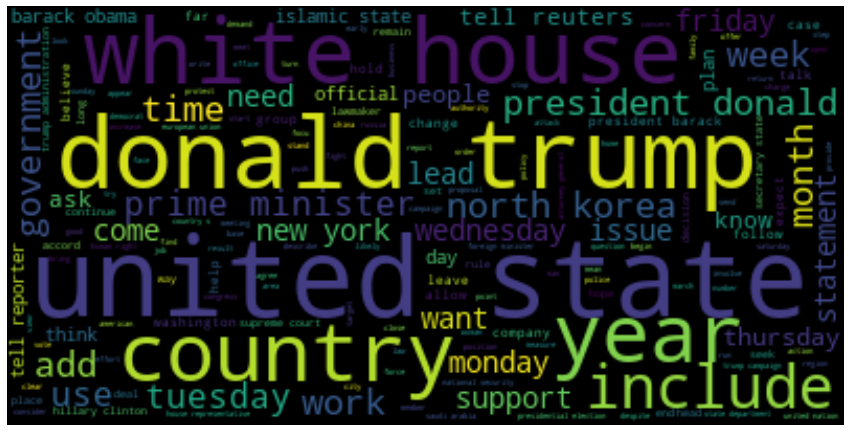

In [21]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(true_list))

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
def word_frequency(sentence):
# joins all the sentences
    sentence =" ".join(sentence)
# creates tokens, removes upper case, removes numbers, symbols and punctuation and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
#counts the words, pairs and trigrams
    counted = Counter(new_tokens)
    counted_2= Counter(ngrams(new_tokens,2))
    counted_3= Counter(ngrams(new_tokens,3))
#creates 3 data frames and return thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    return word_freq,word_pairs,trigrams

In [188]:
token_text_real = word_frequency(df_true.text)

In [189]:
pickle_out = open('pickled_files/nltk_token_text_real.pickle',"wb")
pickle.dump(token_text_real, pickle_out)
pickle_out.close()

In [23]:
infile = open('pickled_files/nltk_token_text_real.pickle','rb')
token_text_real = pickle.load(infile)
infile.close()

<AxesSubplot:xlabel='frequency', ylabel='trigrams'>

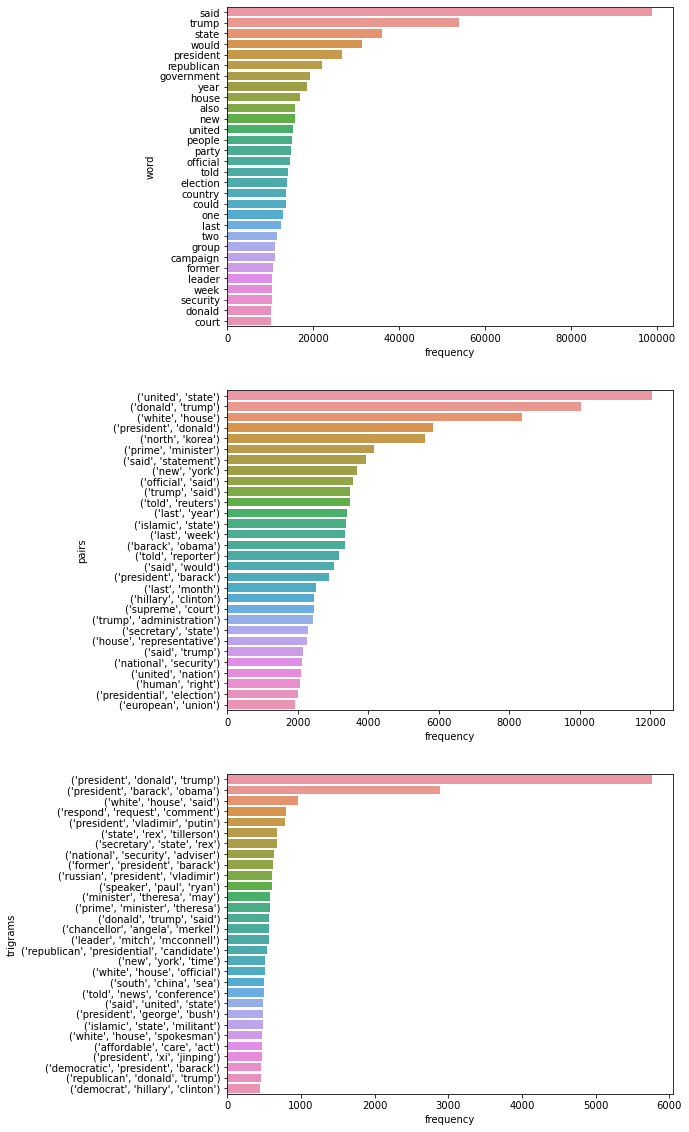

In [24]:
# create subplot of the different data frames
fig, axes = plt.subplots(3,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=token_text_real[0].head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=token_text_real[1].head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=token_text_real[2].head(30))

In [25]:
# Create a new list of stopwords
stopwords = ['``', 's', 'c', "'", ",", "t", "l", 'j', '...', ":", '0', '1', '2', 'couldn', 'wouldn', 'isn', 'aren', 'shouldn', 'don', 'doesn', 'didn']
# Create a new tokenized list to use in the frequency distribution tables
true_tokenized_word = nltk.word_tokenize(str(true_list))

In [26]:
# Iterate through new tokenized list and remove additional stopwords.
true_tokenized_word = [word for word in true_tokenized_word if word not in stopwords]

In [27]:
# Create frequency distribution for the words in the real articles
true_fdist=nltk.FreqDist(true_tokenized_word)

In [28]:
print(true_fdist.most_common(20))

[('trump', 53953), ('president', 24744), ('state', 24139), ('government', 19384), ('year', 19200), ('house', 16618), ('new', 15667), ('tell', 15494), ('people', 15211), ('party', 14945), ('united', 14787), ('republican', 14617), ('official', 14457), ('country', 13965), ('election', 13854), ('states', 12316), ('include', 12154), ('campaign', 11592), ('group', 11053), ('vote', 10886)]


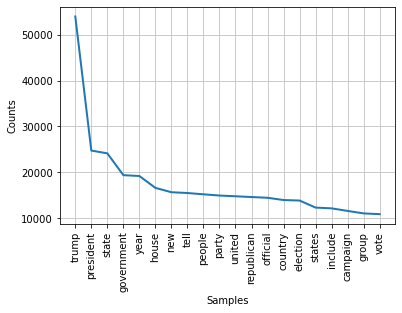

In [29]:
# Plot frequency distribution for the 20 most common words
true_fdist.plot(20)
plt.show()

In [30]:
# Get a list of all the bi-grams
true_bigrams = ngrams(true_tokenized_word, 2)

In [31]:
# List 20 most common bigrams
true_bigrams_freq = collections.Counter(true_bigrams)
true_bigrams_freq.most_common(20)

[(('united', 'states'), 11844),
 (('donald', 'trump'), 9816),
 (('white', 'house'), 8121),
 (('north', 'korea'), 5527),
 (('president', 'donald'), 4270),
 (('prime', 'minister'), 4100),
 (('new', 'york'), 3620),
 (('tell', 'reuters'), 3515),
 (('islamic', 'state'), 3321),
 (('barack', 'obama'), 3317),
 (('tell', 'reporter'), 3242),
 (('president', 'barack'), 2517),
 (('hillary', 'clinton'), 2426),
 (('supreme', 'court'), 2365),
 (('trump', 'administration'), 2343),
 (('secretary', 'state'), 2121),
 (('national', 'security'), 2112),
 (('house', 'representatives'), 2048),
 (('presidential', 'election'), 2015),
 (('united', 'nations'), 1970)]

In [32]:
true_bigram_fdist=nltk.FreqDist(true_bigrams_freq)

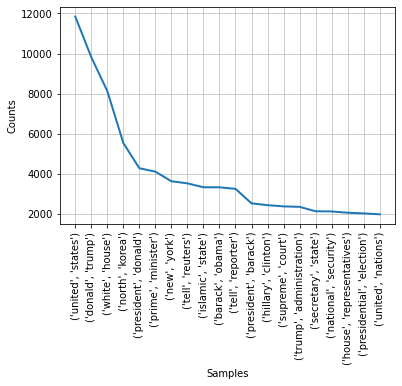

In [33]:
true_bigram_fdist.plot(20)
plt.show()

In [34]:
# Get a list of all the tri-grams
true_trigrams = ngrams(true_tokenized_word, 3)

In [35]:
# List 20 most common tri-grams
true_trigrams_freq = collections.Counter(true_trigrams)
true_trigrams_freq.most_common(20)

[(('president', 'donald', 'trump'), 4208),
 (('president', 'barack', 'obama'), 2510),
 (("'president", 'donald', 'trump'), 1558),
 (('respond', 'request', 'comment'), 832),
 (('president', 'vladimir', 'putin'), 764),
 (('state', 'rex', 'tillerson'), 671),
 (('george', 'w', 'bush'), 662),
 (('national', 'security', 'adviser'), 625),
 (('speaker', 'paul', 'ryan'), 606),
 (('leader', 'mitch', 'mcconnell'), 568),
 (('un', 'security', 'council'), 552),
 (('democratic', 'president', 'barack'), 545),
 (('chancellor', 'angela', 'merkel'), 539),
 (('secretary', 'state', 'rex'), 538),
 (('prime', 'minister', 'theresa'), 536),
 (('presidentelect', 'donald', 'trump'), 532),
 (('speak', 'condition', 'anonymity'), 519),
 (('new', 'york', 'times'), 516),
 (('russian', 'president', 'vladimir'), 509),
 (('white', 'house', 'official'), 502)]

In [36]:
true_trigram_fdist=nltk.FreqDist(true_trigrams_freq)

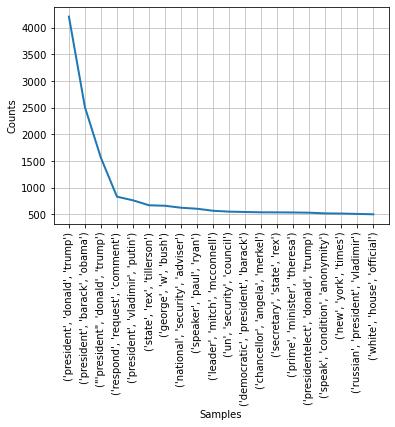

In [37]:
true_trigram_fdist.plot(20)
plt.show()

**Fake News**

In [39]:
# Import Fake news articles
df_fake = pd.read_csv('Fake.csv')
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [40]:
# Create target column
df_fake = df_fake.assign(status = 'Fake')
df_fake.head()

,title,text,subject,date,status
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [41]:
df_fake.shape

(23481, 5)

In [42]:
# Check for missing data
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
status     0
dtype: int64

In [ ]:
# Apply tokenization function to the real articles. Create a new column for the processed articles
df_fake['processed_articles'] = df_fake['text'].map(lambda x: normalize(x))

In [ ]:
list(df_fake.processed_articles)

In [ ]:
# Save the new processed data frame
pickle_out = open('pickled_files/df_spacy_fake.pickle',"wb")
pickle.dump(df_fake, pickle_out)
pickle_out.close()

In [43]:
infile = open('pickled_files/df_spacy_fake.pickle','rb')
df_fake = pickle.load(infile)
infile.close()

In [44]:
fake_text = df_fake.processed_articles

In [45]:
# Create a list of all of the tokenized words
fake_list = []
for x in fake_text:
    fake_list.append(x)

In [46]:
len(str(fake_list))

36692492

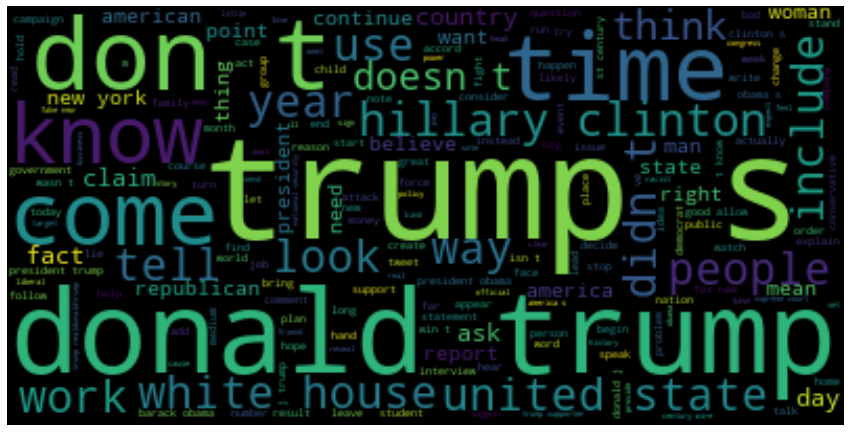

In [47]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str(fake_list))

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [207]:
token_text_fake = word_frequency(df_fake.text)

In [208]:
pickle_out = open('pickled_files/nltk_token_text_fake.pickle',"wb")
pickle.dump(token_text_fake, pickle_out)
pickle_out.close()

In [48]:
infile = open('pickled_files/nltk_token_text_fake.pickle','rb')
token_text_fake = pickle.load(infile)
infile.close()

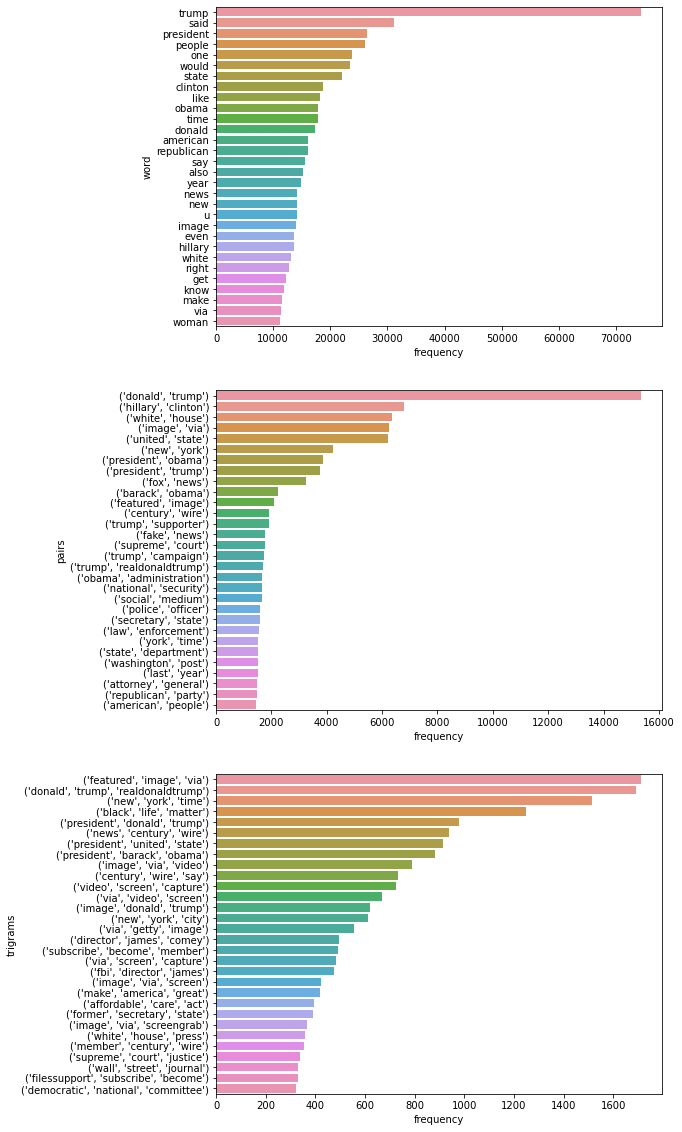

In [49]:
# create subplot of the different data frames
fig, axes = plt.subplots(3,1,figsize=(8,20))
sns.barplot(ax=axes[0],x='frequency',y='word',data=token_text_fake[0].head(30))
sns.barplot(ax=axes[1],x='frequency',y='pairs',data=token_text_fake[1].head(30))
sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=token_text_fake[2].head(30));

In [50]:
# Create a new tokenized list to use in the frequency distribution tables
fake_tokenized_word = nltk.word_tokenize(str(fake_list))

In [51]:
# Iterate through new tokenized list and remove additional stopwords.
fake_tokenized_word = [word for word in fake_tokenized_word if word not in stopwords]

In [52]:
# Create frequency distribution for the words in the real articles
fake_fdist = nltk.FreqDist(fake_tokenized_word)

In [53]:
print(fake_fdist.most_common(20))

[('trump', 73656), ('people', 25945), ('president', 25760), ('like', 18317), ('clinton', 17984), ('obama', 17613), ('state', 17403), ('know', 16247), ('donald', 15813), ('time', 15079), ('year', 15049), ('tell', 14510), ('new', 14147), ('news', 14089), ('come', 13587), ('hillary', 13281), ('white', 13026), ('think', 12272), ('want', 12032), ('use', 11999)]


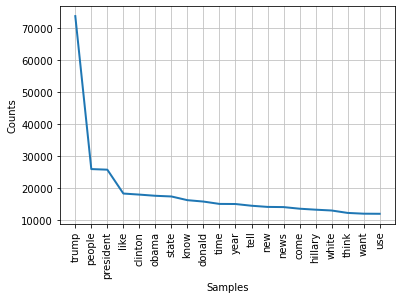

In [54]:
# Plot frequency distribution for the 20 most common words
fake_fdist.plot(20)
plt.show()

In [55]:
# Get a list of all the bi-grams
fake_bigrams = ngrams(fake_tokenized_word, 2)

In [56]:
# List 20 most common bi-grams
fake_bigrams_freq = collections.Counter(fake_bigrams)
fake_bigrams_freq.most_common(20)

[(('donald', 'trump'), 13901),
 (('hillary', 'clinton'), 6554),
 (('white', 'house'), 6230),
 (('united', 'states'), 6143),
 (('new', 'york'), 4142),
 (('president', 'obama'), 3731),
 (('president', 'trump'), 3527),
 (('fox', 'news'), 3101),
 (('barack', 'obama'), 2176),
 (('century', 'wire'), 1926),
 (('trump', 'supporter'), 1885),
 (('trump', 'campaign'), 1790),
 (('fake', 'news'), 1771),
 (('supreme', 'court'), 1751),
 (('trump', 'realdonaldtrump'), 1694),
 (('obama', 'administration'), 1643),
 (('national', 'security'), 1629),
 (('social', 'medium'), 1597),
 (('police', 'officer'), 1564),
 (('law', 'enforcement'), 1552)]

In [57]:
fake_ngram_fdist=nltk.FreqDist(fake_bigrams_freq)

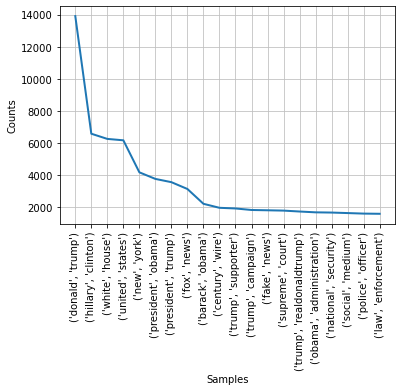

In [58]:
fake_ngram_fdist.plot(20)
plt.show()

In [59]:
# Get a list of all the tri-grams
fake_trigrams = ngrams(fake_tokenized_word, 3)

In [60]:
# List 20 most common tri-grams
fake_trigrams_freq = collections.Counter(fake_trigrams)
fake_trigrams_freq.most_common(20)

[(('donald', 'trump', 'realdonaldtrump'), 1692),
 (('new', 'york', 'times'), 1458),
 (('st', 'century', 'wire'), 1225),
 (('news', 'st', 'century'), 941),
 (('president', 'donald', 'trump'), 915),
 (('president', 'united', 'states'), 901),
 (('president', 'barack', 'obama'), 832),
 (('black', 'life', 'matter'), 812),
 (('subscribe', 'member', 'wiretv'), 737),
 (('video', 'screen', 'capture'), 728),
 (('image', 'video', 'screen'), 697),
 (("'st", 'century', 'wire'), 679),
 (('images', "'donald", 'trump'), 619),
 (('new', 'york', 'city'), 596),
 (('george', 'w', 'bush'), 559),
 (('director', 'james', 'comey'), 479),
 (('wire', 'subscribe', 'member'), 465),
 (('fbi', 'director', 'james'), 458),
 (('image', 'screen', 'capture'), 446),
 (('affordable', 'care', 'act'), 391)]

In [61]:
fake_trigram_fdist=nltk.FreqDist(fake_trigrams_freq)

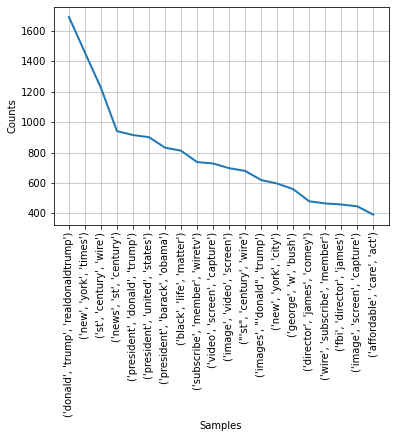

In [62]:
fake_trigram_fdist.plot(20)
plt.show()

**Join data frames**

In [6]:
# Concatenate the two dataframes
frames = [df_true, df_fake]
df=pd.concat(frames)

In [7]:
df.head()

,title,text,subject,date,status,processed_articles
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",Real,head conservative republican faction congress ...
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",Real,transgender people allow time enlist military ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",Real,special counsel investigation link russia pres...
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",Real,trump campaign adviser george papadopoulos tel...
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",Real,president donald trump postal service friday c...


In [8]:
df.tail()

,title,text,subject,date,status,processed_articles
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",Fake,st century wire wire report early week unlikel...
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",Fake,st century wire s familiar theme dispute chang...
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",Fake,patrick henningsen st century wireremember ob...
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",Fake,st century wire al jazeera america history big...
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",Fake,st century wire wire predict new year look ahe...


In [9]:
df.shape

(44877, 6)

In [10]:
# Shuffle rows
df = df.sample(frac = 1)

In [11]:
df.head()

,title,text,subject,date,status,processed_articles
16502,WATCH: TREY GOWDY FURIOUS OVER LAWLESS Loretta...,The lawless and in-your-face behavior that thi...,Government News,"Jul 13, 2016",Fake,lawless inyourface behavior president regime...
9465,Senate approves $1.1 billion to fight Zika virus,An election-year fight over addressing the spr...,politicsNews,"May 19, 2016",Real,electionyear fight address spread zika virus i...
22043,Confirmed: FBI Raids Home of Former Trump Mana...,21st Century Wire says It s been confirmed tha...,US_News,"August 10, 2017",Fake,st century wire s confirm fbi conduct predawn ...
14957,Turkish plane investigated in Copenhagen airpo...,Danish police were investigating a plane at Co...,worldnews,"November 13, 2017",Real,danish police investigate plane copenhagen air...
5994,Trump's plan to halt 'catch and release' of mi...,President Donald Trump’s plan to end the polic...,politicsNews,"January 26, 2017",Real,"president donald trump plan end policy "" catch..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44877 entries, 16502 to 12285
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               44877 non-null  object
 1   text                44877 non-null  object
 2   subject             44877 non-null  object
 3   date                44877 non-null  object
 4   status              44877 non-null  object
 5   processed_articles  44877 non-null  object
dtypes: object(6)
memory usage: 2.4+ MB


In [13]:
# Check for missing data
df.isnull().sum()

title                 0
text                  0
subject               0
date                  0
status                0
processed_articles    0
dtype: int64

## Train test split

In [14]:
# Separate features and labels 
X = df['processed_articles']
y = df.status

# Create test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Modeling

### Dummy Classifier

In [113]:
# Run dummy classifier to get baseline prediction
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.5232301624440137

In [114]:
# Create function to evaluate model and display confusion matrix
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    
    print(classification_report(y, y_pred))
    
    plot_confusion_matrix(model, X, y, cmap='Blues', xticks_rotation='vertical')

C:\Users\acumu\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        Fake       0.52      1.00      0.69     23481
        Real       0.00      0.00      0.00     21396

    accuracy                           0.52     44877
   macro avg       0.26      0.50      0.34     44877
weighted avg       0.27      0.52      0.36     44877



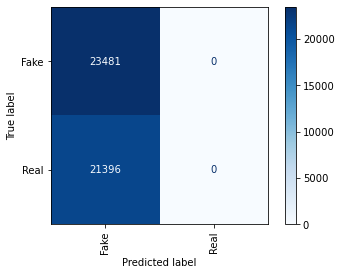

In [115]:
evaluate_model(dummy_clf, X, y)

### Vectorizer and Models for Streamlit

In [103]:
len(df)

44877

In [127]:
vectorizer = TfidfVectorizer()

In [ ]:
# Save the model
pickle_out = open('pickled_files/vectorizer.pickle',"wb")
pickle.dump(vectorizer, pickle_out)
pickle_out.close()

In [128]:
#fit or fit_transform
news_vectorizer = vectorizer.fit_transform(X,y)

In [19]:
type(news_vectorizer)

sklearn.feature_extraction.text.TfidfVectorizer

In [29]:
# Save the model
pickle_out = open('pickled_files/news_vectorizer.pickle',"wb")
pickle.dump(news_vectorizer, pickle_out)
pickle_out.close()

In [27]:
infile = open('pickled_files/news_vectorizer.pickle','rb')
news_vectorizer = pickle.load(infile)
infile.close()

In [23]:
lr = LogisticRegression(solver='saga', 
                              max_iter = 500, 
                              C=1, 
                              penalty='l2', 
                              verbose=1, 
                              n_jobs=-1,
                              random_state=42)

In [90]:
streamlit_lr_model = lr.fit(news_vectorizer, y)

In [ ]:
# Save the model
pickle_out = open('pickled_files/streamlit_lr_model.pickle',"wb")
pickle.dump(streamlit_lr_model, pickle_out)
pickle_out.close()

In [68]:
infile = open('pickled_files/streamlit_lr_model.pickle','rb')
streamlit_lr_model = pickle.load(infile)
infile.close()

In [33]:
nb = MultinomialNB(alpha=0)

In [34]:
streamlit_nb_model = nb.fit(news_vectorizer, y)

C:\Users\acumu\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [35]:
# Save the model
pickle_out = open('pickled_files/streamlit_nb_model.pickle',"wb")
pickle.dump(streamlit_nb_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/streamlit_nb_model.pickle','rb')
streamlit_nb_model = pickle.load(infile)
infile.close()

In [36]:
rforest = RandomForestClassifier(n_estimators=10)

In [37]:
streamlit_rf_model = rforest.fit(news_vectorizer, y)

In [38]:
# Save the model
pickle_out = open('pickled_files/streamlit_rf_model.pickle',"wb")
pickle.dump(streamlit_rf_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/streamlit_rf_model.pickle','rb')
streamlit_rf_model = pickle.load(infile)
infile.close()

In [129]:
vc = VotingClassifier(
                estimators=[('LogisticRegression', lr), ('randomforest', rf), ('NaiveBayes', nb)], 
                voting='soft')

In [130]:
streamlit_vc_model = vc.fit(news_vectorizer, y)

C:\Users\acumu\anaconda3\envs\learn-env\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [131]:
# Save the model
pickle_out = open('pickled_files/streamlit_vc_model.pickle',"wb")
pickle.dump(streamlit_vc_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/streamlit_vc_model.pickle','rb')
streamlit_vc_model = pickle.load(infile)
infile.close()

### Logistic Regression

**Simple Logistic Regression Pipeline** 

In [116]:
# Create a simple logistic regression pipeline including model and vectorizer 
lr_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [117]:
# Fit the pipeline to the training data
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('lr', LogisticRegression())])

In [118]:
pd.DataFrame(lr_pipeline.predict(X_test)).value_counts()

Fake    5809
Real    5411
dtype: int64

              precision    recall  f1-score   support

        Fake       0.99      0.98      0.98     17656
        Real       0.98      0.98      0.98     16001

    accuracy                           0.98     33657
   macro avg       0.98      0.98      0.98     33657
weighted avg       0.98      0.98      0.98     33657



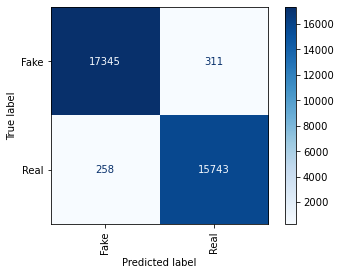

In [119]:
evaluate_model(lr_pipeline, X_train, y_train)

              precision    recall  f1-score   support

        Fake       0.97      0.97      0.97      5825
        Real       0.97      0.97      0.97      5395

    accuracy                           0.97     11220
   macro avg       0.97      0.97      0.97     11220
weighted avg       0.97      0.97      0.97     11220



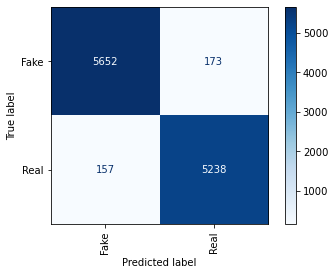

In [120]:
evaluate_model(lr_pipeline, X_test, y_test)

**Logistic Regression Pipeline with hyperparameters tuned**

In [ ]:
# Create a logistic regression pipeline including a tuned model and vectorizer
lr_pipeline2 = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=.9, ngram_range = (1, 2))),
    ('lr', LogisticRegression(solver='saga', 
                              max_iter = 500, 
                              C=1, 
                              penalty='l2', 
                              verbose=1, 
                              n_jobs=-1,
                              random_state=42))
])

In [ ]:
# Fit the model to the training data
lr_pipeline2.fit(X_train, y_train)

In [ ]:
pd.DataFrame(lr_pipeline2.predict(X_test)).value_counts()

In [ ]:
evaluate_model(lr_pipeline2, X_train, y_train)

In [ ]:
evaluate_model(lr_pipeline2, X_test, y_test)

**Logistic Regression Pipeline with Gridsearch**

In [ ]:
# Create a logistic regression pipeline including a tuned model and vectorizer
lr_pipeline_3 = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression(class_weight='balanced', solver='saga', random_state=42))
])

In [ ]:
# Define gridsearch parameters
lr_param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'lr__max_iter': [500, 1000],
    'vectorizer__max_df': np.linspace(.7,1,5),
    'vectorizer__min_df': [10],
    'vectorizer__ngram_range': [(1, 2)]
}

In [ ]:
# Combine logistic regression pipeline with gridsearch
lr_grid = GridSearchCV(lr_pipeline_3, 
                       lr_param_grid,
                       cv=5,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1)

In [ ]:
# Fit pipeline with gridsearch to the training data
lr_grid.fit(X_train, y_train)

In [ ]:
# Display best parameters
lr_grid.best_params_

In [ ]:
evaluate_model(lr_grid, X_train, y_train)

In [ ]:
evaluate_model(lr_grid, X_test, y_test)

In [ ]:
lr_model_train = lr_grid.best_estimator_.fit(X_train, y_train)

In [ ]:
# Save the training model
pickle_out = open('pickled_files/lr_model_train.pickle',"wb")
pickle.dump(lr_model_train, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/lr_model_train.pickle','rb')
lr_model_train = pickle.load(infile)
infile.close()

In [ ]:
lr_model = lr_grid.best_estimator_.fit(X, y)

In [ ]:
# Save the model
pickle_out = open('pickled_files/lr_model.pickle',"wb")
pickle.dump(lr_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/lr_model.pickle','rb')
lr_model = pickle.load(infile)
infile.close()

### Naive Bayes

**Naive Bayes Pipeline**

In [ ]:
# Create a tuned multinomial naive bayes pipeline including a model and vectorizer
nb_pipeline = imbPipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=0.9)),
    ('nb', MultinomialNB())
])

In [ ]:
# Fit the pipeline to the training data
nb_pipeline.fit(X_train, y_train)

In [ ]:
evaluate_model(nb_pipeline, X_train, y_train)

In [ ]:
evaluate_model(nb_pipeline, X_test, y_test)

**Naive Bayes Pipeline with Gridsearch**

In [ ]:
# Create a  multinomial naive bayes pipeline including a model and vectorizer
nb_pipeline_2 = imbPipeline(steps=[
    ('vectorizer', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [ ]:
# Define gridsearch parameters
nb_param_grid = {
    'nb__alpha': np.linspace(0, 4, 10),
    'vectorizer__max_df': np.linspace(.8,1,5),
    'vectorizer__min_df': [10],
    'vectorizer__norm': ['l1', 'l2']
    }

In [ ]:
# Combine Naive Bayes pipeline with gridsearch
nb_grid = GridSearchCV(nb_pipeline_2, 
                       nb_param_grid,
                       cv=5,
                       scoring='f1_weighted',
                       verbose=1,
                       n_jobs=-1)

In [ ]:
# Fit pipeline with gridsearch 
nb_grid.fit(X_train, y_train)

In [ ]:
# Display best parameters
nb_grid.best_params_

In [ ]:
evaluate_model(nb_grid, X_train, y_train)

In [ ]:
evaluate_model(nb_grid, X_test, y_test)

In [ ]:
nb_model_train = nb_grid.best_estimator_.fit(X_train, y_train)

In [ ]:
# Save the training model
pickle_out = open('pickled_files/nb_model_train.pickle',"wb")
pickle.dump(nb_model_train, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/nb_model_train.pickle','rb')
nb_model_train = pickle.load(infile)
infile.close()

In [ ]:
nb_model = nb_grid.best_estimator_.fit(X, y)

In [ ]:
# Save the model
pickle_out = open('pickled_files/nb_model.pickle',"wb")
pickle.dump(nb_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/nb_model.pickle','rb')
nb_model = pickle.load(infile)
infile.close()

### Random Forest

**Simple Random Forest Pipleline**

In [ ]:
# Create a tuned random forest classifier pipeline including a model and vectorizer 
rf_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10, max_df=0.9)),
    ('rf', RandomForestClassifier(n_estimators=10)),
])

In [ ]:
# Fit the pipeline to the training data
rf_pipeline.fit(X_train, y_train)

In [ ]:
pd.DataFrame(rf_pipeline.predict(X_test)).value_counts()

In [ ]:
# Display f1-score for the testing data
f1_score(y_test, rf_pipeline.predict(X_test), average = 'weighted')

In [ ]:
evaluate_model(rf_pipeline, X_train, y_train)

In [ ]:
evaluate_model(rf_pipeline, X_test, y_test)

In [ ]:
rf_model_train = rf_pipeline.fit(X_train, y_train)

In [ ]:
# Save the training model
pickle_out = open('pickled_files/rf_model_train.pickle',"wb")
pickle.dump(rf_model_train, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/rf_model_train.pickle','rb')
rf_model_train = pickle.load(infile)
infile.close()

In [ ]:
rf_model = rf_pipeline.fit(X, y)

In [ ]:
# Save the training model
pickle_out = open('pickled_files/rf_model.pickle',"wb")
pickle.dump(rf_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/rf_model.pickle','rb')
rf_model = pickle.load(infile)
infile.close()

### Voting Classifier

In [40]:
# instantiate the three models already used with the best hyper parameters from grid search where applicable
lr=LogisticRegression(C=10, max_iter=500, penalty='l2')
nb=MultinomialNB(alpha=0.0)
rf=RandomForestClassifier(n_estimators=10)

In [ ]:
# Create a voting classifier pipeline including the three models listed above and a vecotrizer
vc_pipeline = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(min_df=10,max_df=.8)),
    ('vc', VotingClassifier(
                estimators=[('LogisticRegression', lr), ('randomforest', rf), ('NaiveBayes', nb)], 
                voting='hard')),
    
])

In [ ]:
# fit the model to the training data
vc_pipeline.fit(X_train, y_train)

In [ ]:
# Display the f-1 score for the testing data
f1_score(y_test, vc_pipeline.predict(X_test),average = 'weighted')

In [ ]:
evaluate_model(vc_pipeline, X_train, y_train)

In [ ]:
evaluate_model(vc_pipeline, X_test, y_test)

In [ ]:
vc_model_train = vc_pipeline.fit(X_train, y_train)

In [ ]:
# Save the training model
pickle_out = open('pickled_files/vc_model_train.pickle',"wb")
pickle.dump(vc_model_train, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/vc_model_train.pickle','rb')
vc_model_train = pickle.load(infile)
infile.close()

In [ ]:
vc_model = vc_pipeline.fit(X, y)

In [ ]:
# Save the model
pickle_out = open('pickled_files/vc_model.pickle',"wb")
pickle.dump(vc_model, pickle_out)
pickle_out.close()

In [ ]:
infile = open('pickled_files/vc_model.pickle','rb')
vc_model = pickle.load(infile)
infile.close()

**Fin**